<a href="https://colab.research.google.com/github/SolKhanh/Sentiment-Analysis-Twitter/blob/main/Ph%C3%A2n_lo%E1%BA%A1i_c%E1%BA%A3m_x%C3%BAc_Twitter_ML_T5_Nh%C3%B3m19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/ML'

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML


Đọc dữ liệu từ dataset và giảm kích thước xuống còn 10000

In [79]:
df_full = pd.read_csv('Sentiment140.csv', encoding='latin1')
df = df_full.sample(n=10000, random_state=1)
print("Kích thước mẫu dữ liệu:",df.shape)

df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
# object trong pandas đại diện cho chuỗi
print("Kiểu dữ liệu\n",df.dtypes)
df = df[['target','text']]
# Tạo cột Sentiment để đánh giá cảm xúc, không dùng label encoder để dễ nhìn
sentiment_map = {0: "- Tiêu cực", 2: "Trung lập", 4: "+ Tích cực"}
def convert_label(x):
  return sentiment_map[x]
df['Cảm xúc'] = df['target'].apply(convert_label)
df.head()

Kích thước mẫu dữ liệu: (10000, 6)
Kiểu dữ liệu
 target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object


,target,text,Cảm xúc
120640,0,i have to write a speech on &quot;speeches&quo...,- Tiêu cực
189703,0,"Yeah, this is just great, sick in the middle o...",- Tiêu cực
1595284,4,"anyway, gotta go.. CSI: NY up next and I have ...",+ Tích cực
1021096,4,@skimhannahkeys @AliciaSkimbit i like your app...,+ Tích cực
98291,0,@Lolene ummmmm.... U disappeared... So much fo...,- Tiêu cực


Cảm xúc
- Tiêu cực    5014
+ Tích cực    4986
Name: count, dtype: int64
Missing Values:
target     0
text       0
Cảm xúc    0
dtype: int64
-> Không có Missing Values


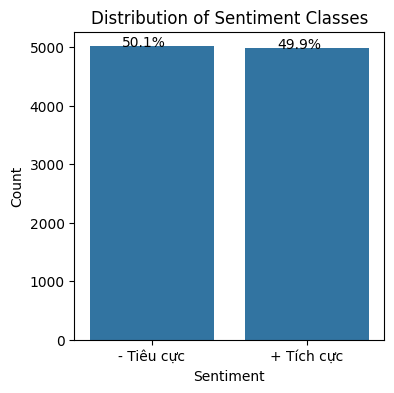

In [80]:
# Count các giá trị của các tweet
target_counts = df['Cảm xúc'].value_counts()
print(target_counts)
print("Missing Values:")
print(df.isnull().sum())
print("-> Không có Missing Values")

# plot
plt.figure(figsize=(4,4))
ax = sns.countplot(x='Cảm xúc', data=df)
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')

#Hiển thị theo %
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

In [81]:
# preprocesssing
def preprocess_text(text):
    text = text.lower() # Chuyển đổi thành chữ thường
    text = re.sub(r'http\S+', '', text) # Xóa URL
    text = re.sub(r'@\w+', '', text) # Xóa tên người dùng
    text = re.sub(r'#(\w+)', r'\1', text) # xóa dấu '#' trong hashtag
    text = re.sub(r'[^a-zA-Z\s0-9]', '', text) # Xóa ký tự đặc biệt (ngoài chữ và số)
    text = re.sub(r'\s+', ' ', text).strip() # Xóa khoảng trắng thừa
    tokens = text.split() # Xóa stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)
df['text'] = df['text'].astype(str)
df['text_preprocess'] = df['text'].apply(preprocess_text)

# Điều chỉnh nhãn cho phân loại nhị phân (0 cho negative, 1 cho positive)
y = df['target'].apply(lambda x: 0 if x == 0 else 1).values

# Tokenization và Padding
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=100)
print(df[['text','text_preprocess']].head())

                                                      text  \
120640   i have to write a speech on &quot;speeches&quo...   
189703   Yeah, this is just great, sick in the middle o...   
1595284  anyway, gotta go.. CSI: NY up next and I have ...   
1021096  @skimhannahkeys @AliciaSkimbit i like your app...   
98291    @Lolene ummmmm.... U disappeared... So much fo...   

                                           text_preprocess  
120640        write speech quotspeechesquot wtf thanks raz  
189703   yeah great sick middle night cant sleepand gon...  
1595284  anyway gotta go csi ny next asia memorize tyl ...  
1021096  like approach get twitter power 10 promote goo...  
98291                       ummmmm u disappeared much nite  


In [128]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Tạo và huấn luyện mô hình LSTM
y_train_2d = to_categorical(y_train, num_classes=2)
y_val_2d = to_categorical(y_val, num_classes=2)
y_test_2d = to_categorical(y_test, num_classes=2)
# In kích thước của các tập dữ liệu
print('Kích thước X_train:', X_train.shape)
print('Kích thước y_train:', y_train.shape)
print('Kích thước X_val:', X_val.shape)
print('Kích thước y_val:', y_val.shape)
print('Kích thước X_test:', X_test.shape)
print('Kích thước y_test:', y_test.shape)


Kích thước X_train: (7000, 100)
Kích thước y_train: (7000,)
Kích thước X_val: (1500, 100)
Kích thước y_val: (1500,)
Kích thước X_test: (1500, 100)
Kích thước y_test: (1500,)


In [129]:
def build_lstm_model(input_length, vocab_size, embedding_dim=50):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model(X_train.shape[1], tokenizer.num_words)
lstm_history = lstm_model.fit(X_train, y_train_2d, epochs=5, batch_size=64, validation_data=(X_val, y_val_2d), verbose=1)

# Đánh giá mô hình trên tập test
lstm_eval = lstm_model.evaluate(X_test, y_test_2d, verbose=1)
print('LSTM Test accuracy:', lstm_eval[1])

lstm_pred_prob = lstm_model.predict(X_test)
lstm_pred = np.argmax(lstm_pred_prob, axis=1)
y_test_lstm = np.argmax(y_test_2d, axis=1)

# Tạo báo cáo phân loại cho LSTM
lstm_report = classification_report(y_test_lstm, lstm_pred, target_names=['Negative', 'Positive'])
print("LSTM:")
print(lstm_report)

Epoch 1/5
110/110 [==============================] - 18s 147ms/step - loss: 0.6300 - accuracy: 0.6334 - val_loss: 0.5642 - val_accuracy: 0.7093
Epoch 2/5
110/110 [==============================] - 11s 101ms/step - loss: 0.4836 - accuracy: 0.7774 - val_loss: 0.5463 - val_accuracy: 0.7293
Epoch 3/5
110/110 [==============================] - 11s 99ms/step - loss: 0.4267 - accuracy: 0.8040 - val_loss: 0.5455 - val_accuracy: 0.7347
Epoch 4/5
110/110 [==============================] - 9s 82ms/step - loss: 0.3912 - accuracy: 0.8296 - val_loss: 0.5457 - val_accuracy: 0.7287
Epoch 5/5
47/47 [==============================] - 1s 17ms/step - loss: 0.5845 - accuracy: 0.7260
LSTM Test accuracy: 0.7260000109672546
47/47 [==============================] - 1s 17ms/step
LSTM:
              precision    recall  f1-score   support

    Negative       0.70      0.77      0.73       729
    Positive       0.76      0.69      0.72       771

    accuracy                           0.73      1500
   macro avg

In [130]:
X_train, X_temp, y_train, y_temp = train_test_split(df['text_preprocess'], y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000)),
    ('clf', SVC(kernel='linear', random_state=42))
])
svm_pipeline.fit(X_train, y_train)
svm_pred = svm_pipeline.predict(X_test)

svm_report = classification_report(y_test, svm_pred, target_names=['Negative', 'Positive'])
print("SVM:")
print(svm_report)

mnb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000)),
    ('clf', MultinomialNB())
])

mnb_pipeline.fit(X_train, y_train)
mnb_pred = mnb_pipeline.predict(X_test)

mnb_report = classification_report(y_test, mnb_pred, target_names=['Negative', 'Positive'])
print("Naive Bayes:")
print(mnb_report)


SVM:
              precision    recall  f1-score   support

    Negative       0.72      0.73      0.72       729
    Positive       0.74      0.73      0.73       771

    accuracy                           0.73      1500
   macro avg       0.73      0.73      0.73      1500
weighted avg       0.73      0.73      0.73      1500

Naive Bayes:
              precision    recall  f1-score   support

    Negative       0.69      0.77      0.73       729
    Positive       0.76      0.67      0.71       771

    accuracy                           0.72      1500
   macro avg       0.72      0.72      0.72      1500
weighted avg       0.72      0.72      0.72      1500



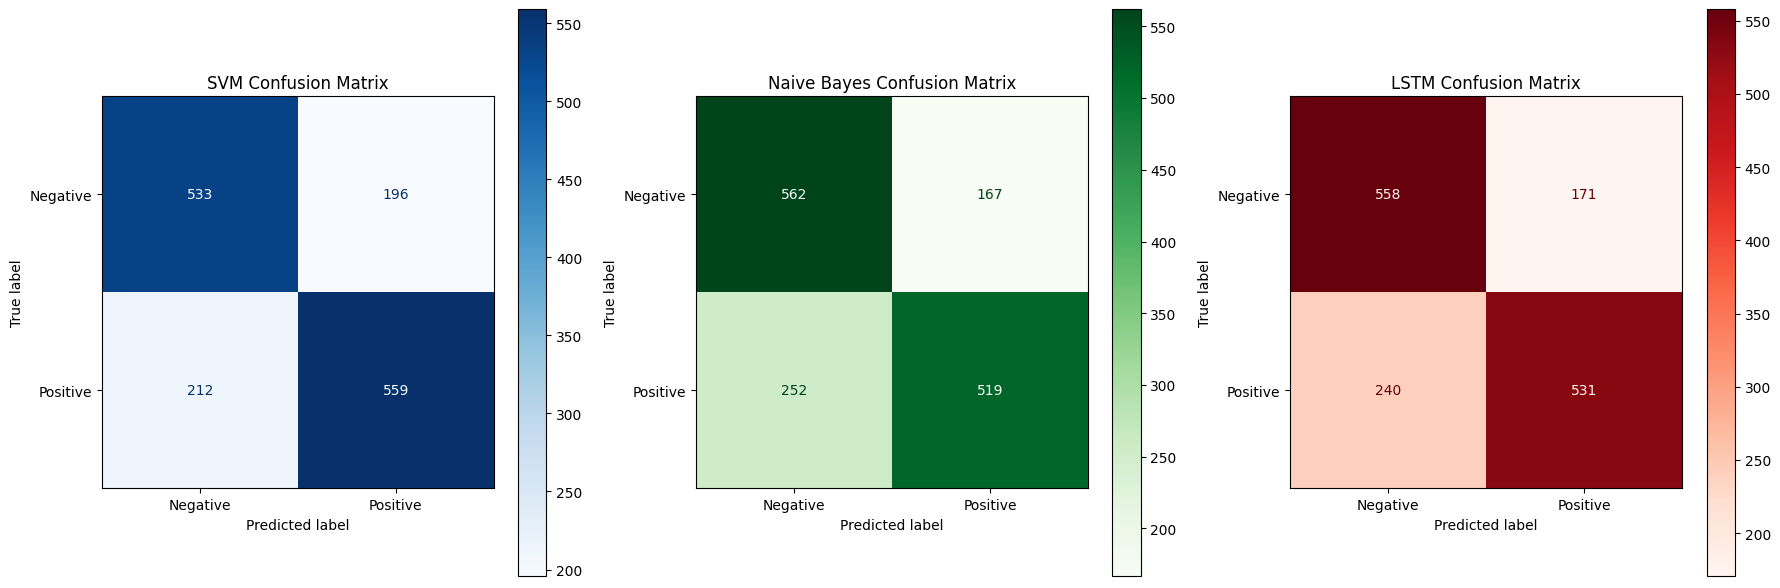

In [132]:
cm_svm = confusion_matrix(y_test, svm_pred, labels=[0, 1])
cm_mnb = confusion_matrix(y_test, mnb_pred, labels=[0, 1])
cm_lstm = confusion_matrix(y_test, lstm_pred, labels=[0, 1])

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

ConfusionMatrixDisplay(cm_svm, display_labels=['Negative', 'Positive']).plot(ax=axs[0], cmap=plt.cm.Blues, values_format='d')
axs[0].set_title('SVM Confusion Matrix')

ConfusionMatrixDisplay(cm_mnb, display_labels=['Negative', 'Positive']).plot(ax=axs[1], cmap=plt.cm.Greens, values_format='d')
axs[1].set_title('Naive Bayes Confusion Matrix')

ConfusionMatrixDisplay(cm_lstm, display_labels=['Negative', 'Positive']).plot(ax=axs[2], cmap=plt.cm.Reds, values_format='d')
axs[2].set_title('LSTM Confusion Matrix')

plt.tight_layout()
plt.show()